In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from keras.models import Model, Sequential #Functional API
from keras.layers import Flatten, Dense, Input, Dropout, GlobalAveragePooling2D, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.optimizers import Adam, SGD, RMSprop

In [2]:
base_path = 'dataset/combined/'

### Displaying Images

In [3]:
picture_size = 48
path = "dataset/combined/"

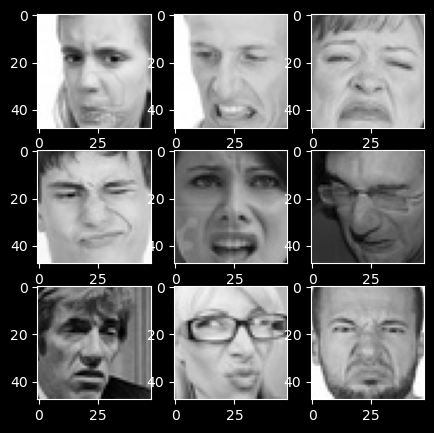

In [4]:
expression = 'disgust'

plt.style.use('dark_background')
plt.figure(figsize = (5,5))
for i in range(1,10,1):
  plt.subplot(3,3,i)
  img = load_img(path+"train/"+expression+"/" +
                 os.listdir(path+"train/"+expression+"/")[i] , target_size = (picture_size,picture_size))
  plt.imshow(img)
plt.show()


### Training and Validation Data

In [5]:
batch_size = 128 #how many training eq in 1 iteration

datagen_train = ImageDataGenerator()
datagen_test = ImageDataGenerator()

train_set = datagen_train.flow_from_directory(path+"train",
                                              target_size = (picture_size,picture_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)
test_set = datagen_test.flow_from_directory(path+"test",
                                              target_size = (picture_size,picture_size),
                                              color_mode = 'grayscale',
                                              batch_size = batch_size,
                                              class_mode = 'categorical',
                                              shuffle = True)


Found 29241 images belonging to 7 classes.
Found 7395 images belonging to 7 classes.


### Model Building

In [6]:
from keras.optimizers import Adam
from keras.metrics import Accuracy, Recall, Precision
from keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [7]:
from keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, Flatten, GlobalAveragePooling2D
from keras.models import Model
from keras.applications.xception import Xception
from keras.regularizers import l2

In [8]:
from keras.layers import Activation, Convolution2D, Dropout, Conv2D
from keras.layers import AveragePooling2D, BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Flatten
from keras.models import Model
from keras.layers import Input
from keras.layers import MaxPooling2D
from keras.layers import SeparableConv2D
from keras import layers
from keras.regularizers import l2

In [9]:
def simple_CNN(input_shape, num_classes):
  model = Sequential()

  #1st CNN layer
  model.add(Conv2D(64,(3,3), padding = 'same', input_shape = (48,48,1))) #(3,3) is kernel size, 64 filters in number, padding same means padding is same on each side
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #2nd CNN layer
  model.add(Conv2D(128,(5,5), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #3rd CNN layer
  model.add(Conv2D(512,(3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  #4th CNN layer
  model.add(Conv2D(512,(3,3), padding = 'same'))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D(pool_size = (2,2)))
  model.add(Dropout(0.25))

  model.add(Flatten()) #collapse the ip to 1d array to feed into fc easily

  #1st FC layer (fully connected)
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  #2nd FC layer
  model.add(Dense(512))
  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(Dropout(0.25))

  model.add(Dense(7, activation = 'softmax'))
  return model



In [10]:
def mini_XCEPTION(input_shape, num_classes, l2_regularization=0.01):
    regularization = l2(l2_regularization)

    # base
    img_input = Input(input_shape)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(img_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (3, 3), strides=(1, 1), kernel_regularizer=regularization,
               use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # module 1
    residual = Conv2D(16, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(16, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 2
    residual = Conv2D(32, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(32, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 3
    residual = Conv2D(64, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(64, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    # module 4
    residual = Conv2D(128, (1, 1), strides=(2, 2),
                      padding='same', use_bias=False)(x)
    residual = BatchNormalization()(residual)

    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = SeparableConv2D(128, (3, 3), padding='same',
                        kernel_regularizer=regularization,
                        use_bias=False)(x)
    x = BatchNormalization()(x)

    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
    x = layers.add([x, residual])

    x = Conv2D(num_classes, (3, 3),
               # kernel_regularizer=regularization,
               padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    output = Activation('softmax', name='predictions')(x)

    model = Model(img_input, output)
    return model

In [11]:
model1 = xcpetion((48, 48, 1), 7)
opt = Adam(learning_rate = 0.0001)
model1.compile(optimizer=opt, 
               loss = 'categorical_crossentropy', 
               metrics=['accuracy'])
model1.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)      

In [12]:
model2 = mini_XCEPTION((64,64, 1), 7)
model2.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])
model2.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 1)]          0         []                            
                                                                                                  
 conv2d_4 (Conv2D)           (None, 62, 62, 8)            72        ['input_1[0][0]']             
                                                                                                  
 batch_normalization_6 (Bat  (None, 62, 62, 8)            32        ['conv2d_4[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 activation_6 (Activation)   (None, 62, 62, 8)            0         ['batch_normalization_6[0

 activation_10 (Activation)  (None, 15, 15, 64)           0         ['batch_normalization_15[0][0]
                                                                    ']                            
                                                                                                  
 separable_conv2d_5 (Separa  (None, 15, 15, 64)           4672      ['activation_10[0][0]']       
 bleConv2D)                                                                                       
                                                                                                  
 batch_normalization_16 (Ba  (None, 15, 15, 64)           256       ['separable_conv2d_5[0][0]']  
 tchNormalization)                                                                                
                                                                                                  
 conv2d_8 (Conv2D)           (None, 8, 8, 64)             2048      ['add_1[0][0]']               
          

### Fitting the model

In [13]:
# parameters
batch_size = 32
num_epochs = 20
input_shape = (64, 64, 1)
validation_split = .2
verbose = 1
num_classes = 7
patience = 50


In [ ]:
# parameters
batch_size = 32
num_epochs = 10000
input_shape = (64, 64, 1)
num_classes = 7
patience = 50

# callbacks
early_stop = EarlyStopping('val_loss', patience=patience)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1,
                              patience=int(patience/4), verbose=1)
model_checkpoint = ModelCheckpoint(filepath = "model.h5",  monitor = 'val_loss', verbose = 1, save_best_ony = True)
callbacks = [model_checkpoint, early_stop, reduce_lr]


model2.fit_generator(generator = train_set,
                    steps_per_epoch=len(train_set) / batch_size,
                    epochs=num_epochs,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=test_set)

Epoch 1/10000


C:\Users\VIT-AP\AppData\Local\Temp\ipykernel_10436\2070171419.py:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(generator = train_set,


8/7 [=================================] - ETA: 0s - loss: 2.1893 - accuracy: 0.2080
Epoch 1: saving model to xception.h5
7/7 [==============================] - 8s 596ms/step - loss: 2.1893 - accuracy: 0.2080 - val_loss: 2.1842 - val_accuracy: 0.1297 - lr: 0.0010
Epoch 2/10000


C:\Users\VIT-AP\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/7 [=================================] - ETA: 0s - loss: 2.0266 - accuracy: 0.2412
Epoch 2: saving model to xception.h5
7/7 [==============================] - 4s 549ms/step - loss: 2.0266 - accuracy: 0.2412 - val_loss: 2.0863 - val_accuracy: 0.2011 - lr: 0.0010
Epoch 3/10000
8/7 [=================================] - ETA: 0s - loss: 1.9040 - accuracy: 0.3037
Epoch 3: saving model to xception.h5
7/7 [==============================] - 3s 537ms/step - loss: 1.9040 - accuracy: 0.3037 - val_loss: 2.0645 - val_accuracy: 0.1281 - lr: 0.0010
Epoch 4/10000
8/7 [=================================] - ETA: 0s - loss: 1.8619 - accuracy: 0.3008
Epoch 4: saving model to xception.h5
7/7 [==============================] - 3s 541ms/step - loss: 1.8619 - accuracy: 0.3008 - val_loss: 2.0693 - val_accuracy: 0.1232 - lr: 0.0010
Epoch 5/10000
8/7 [=================================] - ETA: 0s - loss: 1.8015 - accuracy: 0.3066
Epoch 5: saving model to xception.h5
7/7 [==============================] - 3s 531ms/

In [ ]:
# parameters
batch_size = 128
epochs = 50
input_shape = (48,48, 1)
num_classes = 7

# callbacks
checkpoint = ModelCheckpoint(filepath = "base_cnn.h5", monitor = 'val_acc', verbose = 1, save_best_ony = True, mode = 'max')
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, verbose = 1, restore_best_weights = True)

reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',factor = 0.2, patience = 3, verbose = 1, min_delta = 0.0001)

callbacks_list = [early_stopping, checkpoint, reduce_learningrate]

cnn = model1.fit_generator(generator = train_set,
                              steps_per_epoch = train_set.n//train_set.batch_size,
                              epochs = epochs,
                              validation_data = test_set,
                              validation_steps = test_set.n//test_set.batch_size,
                              callbacks = callbacks_list
                              )

### Plotting Accuracy and Loss

In [ ]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()